Preprocess continuous data for resting state project. Updated pipeline integrating LFPAnalysis automatic IED rejection. Oct 2024.

Load necessary packages

In [3]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
from ast import literal_eval

import warnings
warnings.filterwarnings('ignore')

In [4]:
import sys
sys.path.append('/Users/christinamaher/Documents/GitHub/LFPAnalysis')

In [5]:
from LFPAnalysis import lfp_preprocess_utils

Define directories

In [10]:
subj_id = 'MS001'
subj_format = ['edf']
subj_site = ['MSSM']

# Specify root directory for data and results 
base_dir = '/Users/christinamaher/Desktop/'
anat_dir = f'{base_dir}{subj_id}/'
neural_dir = f'{base_dir}{subj_id}/'
save_dir = f'{base_dir}resting_state/clean_data/{subj_id}'
os.makedirs(save_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data

Import data

In [13]:
glob(f'{neural_dir}/*.edf')

['/Users/christinamaher/Desktop/MS001/MS001_Resting_iEEG.edf']

In [15]:
edf_files = glob(f'{neural_dir}/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)
mne_data

<RawEDF | MS001_Resting_iEEG.edf, 276 x 312000 (609.4 s), ~657.2 MB, data loaded>

Import anat recon information

In [16]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]
elec_locs = elec_locs.dropna(axis=0, how = 'all') #some recons have a bunch of empty rows at the end 
elec_locs

,NMMlabel,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,LaCaS1,A32sg_L,-8.952587,42.765351,7.745169,-9.250443,36.452287,-8.560293,Gray,Left ACgG anterior cingulate gyrus,Area s32,L Mid Orbital Gyrus,L CG,Left cingulate gyrus D,NaN,NaN
1,LaCaS10,A9l_L,-11.351734,49.160169,52.917875,-10.705220,54.795877,41.886395,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 C,NaN,NaN
2,LaCaS11,Unknown,-11.351734,49.160169,57.714976,-10.790170,56.511473,47.589415,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
3,LaCaS12,Unknown,-11.351734,49.160169,62.112319,-10.779800,58.090865,52.761764,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32sg_L,-9.352445,43.564703,12.942029,-9.498693,38.675785,-2.957526,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,RmTpT5,Unknown,40.229932,-32.373764,-14.241546,46.004548,-47.067322,-5.385297,White,Right Cerebral White Matter,Unknown,R Middle Temporal Gyrus,Unknown,Unknown,WM,NaN
124,RmTpT6,A37dl_R,43.828653,-34.771821,-11.842996,49.802904,-48.754227,-1.989788,Gray,Right Cerebral White Matter,Unknown,R Middle Temporal Gyrus,R MTG,Unknown,Right inferior middle temporal gyrus E,NaN
125,RmTpT7,A37dl_R,47.027516,-36.770202,-9.444445,53.100242,-49.935602,1.405315,White,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R MTG,Right superior middle temporal gyrus E,WM,NaN
126,RmTpT8,A37dl_R,51.026095,-38.768583,-7.845411,57.411817,-51.317997,3.928683,Gray,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R MTG,Right superior middle temporal gyrus F,NaN,NaN


Fix edf channel names

In [19]:
if 'NMMlabel' in elec_locs.columns:
    elec_locs['NMMlabel'] = elec_locs['label']
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}
mne_data.rename_channels(new_name_dict)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


<RawEDF | MS001_Resting_iEEG.edf, 276 x 312000 (609.4 s), ~657.2 MB, data loaded>

In [20]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'c125', 'c126', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c160', 'c161', 'c162', 'c163', 'c164', 'c165', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc

In [21]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')

We have a total of 64 left & 64 right sEEG electrodes
We have a total of 128 sEEG electrodes


In [22]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names)) # it is either called DC1 or research
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS001_Resting_iEEG.edf, 128 x 312000 (609.4 s), ~304.8 MB, data loaded>

In [23]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS001_Resting_iEEG.edf, 128 x 312000 (609.4 s), ~304.8 MB, data loaded>

In [24]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS001_Resting_iEEG.edf, 128 x 312000 (609.4 s), ~304.9 MB, data loaded>

Notch filter line noise

In [25]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.5s finished


<RawEDF | MS001_Resting_iEEG.edf, 128 x 312000 (609.4 s), ~304.9 MB, data loaded>

Resample data

In [26]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.4s finished


<RawEDF | MS001_Resting_iEEG.edf, 128 x 304688 (609.4 s), ~297.7 MB, data loaded>

Save raw lfp data

In [27]:
mne_data.save(f'{save_dir}/{subj_id}_raw_ieeg.fif',overwrite=True)

Re-reference data - bipolar re-referencing 
- automatically excludes OOB channels

In [65]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=f'{anat_dir}/{subj_id}_labels.csv', 
                                              method='bipolar', 
                                              site='MSSM')
mne_data_bp_reref

<RawEDF | MS001_Resting_iEEG.edf, 64 x 304688 (609.4 s), ~148.9 MB, data loaded>

Save bp-referenced data

In [30]:
mne_data_bp_reref.save(f'{save_dir}/{subj_id}_raw_ieeg_reref.fif',overwrite=True)

In [33]:
# Read mne_data_bp_reref
mne_data_bp_reref = mne.io.read_raw_fif(f'{save_dir}/{subj_id}_raw_ieeg_reref.fif', preload=True)
print(type(mne_data_bp_reref))


<class 'mne.io.fiff.raw.Raw'>


Apply automatic artifact rejection 

In [67]:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

data_type = 'continuous'

IED_sec_dict = lfp_preprocess_utils.detect_IEDs(mne_data_bp_reref, 
                                            peak_thresh=IED_args['peak_thresh'], 
                                            closeness_thresh=IED_args['closeness_thresh'], 
                                            width_thresh=IED_args['width_thresh'])

artifact_sec_dict = lfp_preprocess_utils.detect_misc_artifacts(mne_data_bp_reref, 
                                            peak_thresh=IED_args['peak_thresh'])   

IED_df = pd.DataFrame.from_dict(IED_sec_dict, orient='index').T
artifact_df = pd.DataFrame.from_dict(artifact_sec_dict, orient='index').T 

# Now, let's iterate through each channel, and each ied/artifact, and NaN 100 ms before and after these timepoints
for ch_ix, ch_name in enumerate(mne_data_bp_reref.ch_names): 
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
    for ev_ in ied_ev_list: 
        ied_value = IED_df[ch_name].iloc[ev_]
        try:
            ied_list = literal_eval(ied_value)
        except (ValueError, SyntaxError):
            ied_list = [ied_value] 
        for ied_ in ied_list:
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * mne_data_bp_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([mne_data_bp_reref._data.shape[-1], np.ceil((ied_ + 0.1) * mne_data_bp_reref.info['sfreq'])]).astype(int)
            mne_data_bp_reref._data[ch_ix, ev_ix_start:ev_ix_end] = np.nan
    for ev_ in artifact_ev_list:
        artifact_value = artifact_df[ch_name].iloc[ev_]
        try:
            artifact_list = literal_eval(artifact_value)
        except (ValueError, SyntaxError):
            artifact_list = [artifact_value]
        for artifact_ in artifact_list:
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * mne_data_bp_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([mne_data_bp_reref._data.shape[-1], np.ceil((artifact_ + 0.1) * mne_data_bp_reref.info['sfreq'])]).astype(int)
            mne_data_bp_reref._data[ch_ix, ev_ix_start:ev_ix_end] = np.nan


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    0.6s finished


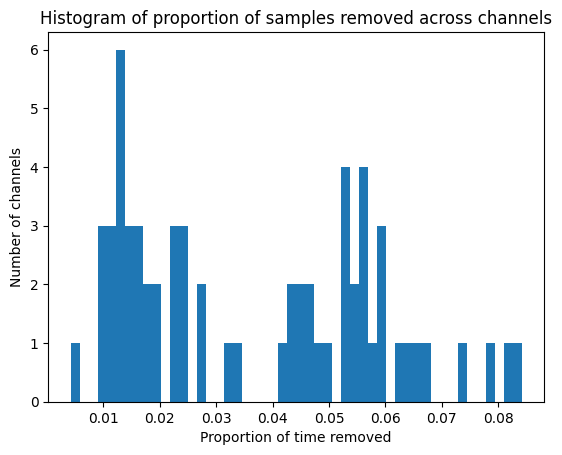

In [68]:
# Plot the proportion of time removed for each channel
prop_removed = np.sum(np.isnan(mne_data_bp_reref._data), axis=1)/mne_data_bp_reref._data.shape[-1]
plt.hist(prop_removed, bins=50)
plt.xlabel('Proportion of time removed')
plt.ylabel('Number of channels')
plt.title('Histogram of proportion of samples removed across channels')
# save the figure
plt.savefig(f'{save_dir}/{subj_id}_prop_removed.png')

plt.show()


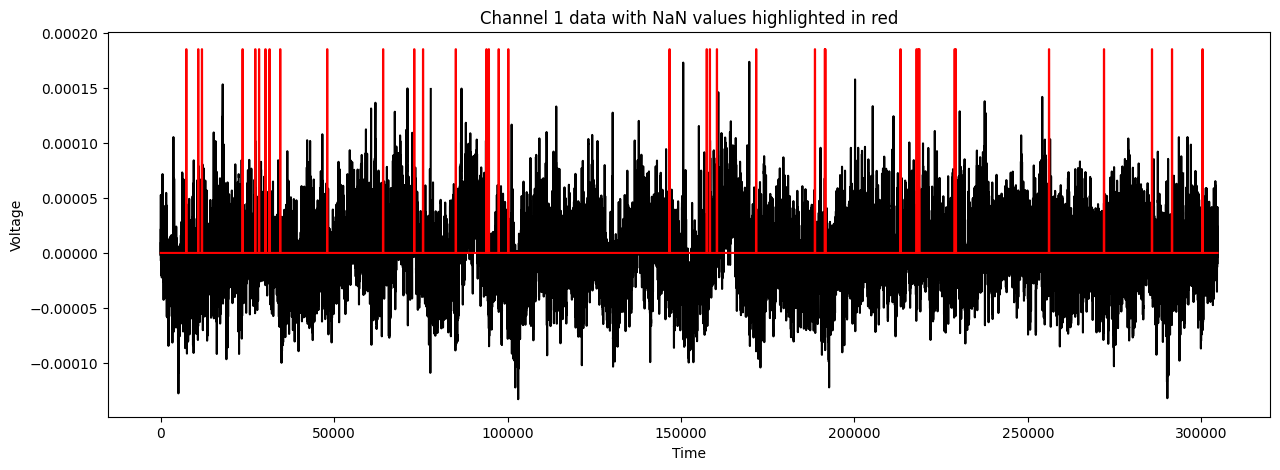

In [64]:
# Plot channel 1 data - highlight np.nan values in red
plt.figure(figsize=(15,5))
plt.plot(mne_data_bp_reref._data[2,:], color='black')
plt.plot(np.isnan(mne_data_bp_reref._data[0,:])*np.nanmax(mne_data_bp_reref._data[0,:]), color='red')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.title('Channel 1 data with NaN values highlighted in red')
plt.show()

In [73]:
# check if there are nan values in the data
print(np.sum(np.isnan(mne_data_bp_reref._data[2,:])))
mne_data_bp_reref._data[2,:]

300000/500/60 # total recording length

4518


10.0

In [58]:
# Save the cleaned data
mne_data_bp_reref.save(f'{save_dir}/{subj_id}_raw_ieeg_reref_cleaned.fif',overwrite=True)

Because this pipeline is fully automatic - we can parallelize it across subjects. 

In [ ]:
# parallelize full preprocessing pipeline across subjects 

def preprocess_pipeline(subj_id, subj_format, subj_site, base_dir):
    # Load the data
    anat_dir = f'{base_dir}{subj_id}/'
    neural_dir = f'{base_dir}{subj_id}/'
    save_dir = f'{base_dir}resting_state/clean_data/{subj_id}'
    os.makedirs(save_dir,exist_ok = True)
    edf_files = glob(f'{neural_dir}/*.edf')
    mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)
    
    # Load the electrode localization data
    anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
    elec_locs = pd.read_csv(anat_file)
    # Sometimes there's extra columns with no entries: 
    elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]
    elec_locs = elec_locs.dropna(axis=0, how = 'all') #some recons have a bunch of empty rows at the end 
    if 'NMMlabel' in elec_locs.columns:
        elec_locs['NMMlabel'] = elec_locs['label']
    new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)
    new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}
    mne_data.rename_channels(new_name_dict)
    anat_names = list(elec_locs.label.str.lower())
    sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
    print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)
    
    # Note, there is surface EEG data that we should separately indicate from the sEEG:
    right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
    left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
    print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
    print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')
    drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names)) # it is either called DC1 or research
    mne_data.drop_channels(drop_chans) #number of chans should = number of seegs
    # Set channel types:
    sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
    mne_data.set_channel_types(sEEG_mapping_dict)
    # make montage (convert mm to m)
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                            elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                            coord_frame='mni_tal')
    mne_data.set_montage(montage, match_case=False, on_missing='warn')
    # Identify line noise
    mne_data.info['line_freq'] = 60
    # Notch out 60 Hz noise and harmonics
    mne_data.notch_filter(freqs=(60, 120, 180, 240))
    #resampling if patient is not sampled at 512
    resample_sr = 500
    mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)
    mne_data.save(f'{save_dir}/{subj_id}_raw_ieeg.fif',overwrite=True)
    # Re-reference neural data
    mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                  elec_path=f'{anat_dir}/{subj_id}_labels.csv', 
                                                  method='bipolar', 
                                                  site='MSSM')
    mne_data_bp_reref.save(f'{save_dir}/{subj_id}_raw_ieeg_reref.fif',overwrite=True)
    # Read mne_data_bp_reref
    mne_data_bp_reref = mne.io.read_raw_fif(f'{save_dir}/{subj_id}_raw_ieeg_reref.fif', preload=True)
    IED_args = {'peak_thresh':4,
               'closeness_thresh':0.25, 
               'width_thresh':0.2}
    data_type = 'continuous'
    IED_sec_dict = lfp_preprocess_utils.detect_IEDs(mne_data_bp_reref, 
                                                peak_thresh=IED_args['peak_thresh'], 
                                                closeness_thresh=IED_args['closeness_thresh'], 
                                                width_thresh=IED_args['width_thresh'])
    artifact_sec_dict = lfp_preprocess_utils.detect_misc_artifacts(mne_data_bp_reref,
                                                peak_thresh=IED_args['peak_thresh'])
    IED_df = pd.DataFrame.from_dict(IED_sec_dict, orient='index').T
    artifact_df = pd.DataFrame.from_dict(artifact_sec_dict, orient='index').T
    # Now, let's iterate through each channel, and each ied/artifact, and NaN 100 ms before and after these timepoints

    for ch_ix, ch_name in enumerate(mne_data_bp_reref.ch_names):
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
        for ev_ in ied_ev_list:
            ied_value = IED_df[ch_name].iloc[ev_]
            try:
                ied_list = literal_eval(ied_value)
            except (ValueError, SyntaxError):
                ied_list = [ied_value]
            for ied_ in ied_list:
                # remove 100 ms before
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * mne_data_bp_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([mne_data_bp_reref._data.shape[-1], np.ceil((ied_ + 0.1) * mne_data_bp_reref.info['sfreq'])]).astype(int)
                mne_data_bp_reref._data[ch_ix, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list:
            artifact_value = artifact_df[ch_name].iloc[ev_]
            try:
                artifact_list = literal_eval(artifact_value)
            except (ValueError, SyntaxError):
                artifact_list = [artifact_value]
            for artifact_ in artifact_list:
                # remove 100 ms before
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * mne_data_bp_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([mne_data_bp_reref._data.shape[-1], np.ceil((artifact_ + 0.1) * mne_data_bp_reref.info['sfreq'])]).astype(int)
                mne_data_bp_reref._data[ch_ix, ev_ix_start:ev_ix_end] = np.nan
    # Plot the proportion of time removed for each channel
    prop_removed = np.sum(np.isnan(mne_data_bp_reref._data), axis=1)/mne_data_bp_reref._data.shape[-1]
    plt.hist(prop_removed, bins=50)
    plt.xlabel('Proportion of samples removed')
    plt.ylabel('Number of channels')
    plt.title('Histogram of proportion of samples removed across channels')
    # save the figure
    plt.savefig(f'{save_dir}/{subj_id}_prop_removed.png')

    # Save the cleaned data
    mne_data_bp_reref.save(f'{save_dir}/{subj_id}_raw_ieeg_reref_cleaned.fif',overwrite=True)
    return

# parallelize full preprocessing pipeline across subjects
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(f'Number of cores: {num_cores}')

# Define the subjects to preprocess
subject_list = ['MS001'...]

# Run the pipeline
Parallel(n_jobs=num_cores)(delayed(preprocess_pipeline)(subj_id, subj_format, subj_site, base_dir) for subj_id in subject_list)


